In [13]:
import zarr # Check version
import numpy as np

zarr.__version__

'2.13.2'

In [14]:
ncar_data = zarr.open("sciserver-experimental/ariel/tests")

In [3]:
ncar_data.info

Name,/
Type,zarr.hierarchy.Group
Read-only,False
Store type,zarr.storage.DirectoryStore
No. members,6
No. arrays,6
No. groups,0
Arrays,"e, p, t, u, v, w"


<font color="orange">ok, the data is compressed. Let's test access time</font>

In [ ]:
chunk_size = 2**i

In [17]:
chunk_size = (256, 256, 256)
print("Chunk Size: ", np.product(np.array(chunk_size)) / (1024**2), " MB")

Chunk Size:  16.0  MB


## Note: Chunk size = 256^3

In [18]:
a = np.empty(shape=(chunk_size))

In [19]:
%%timeit -o -n 1 -r 1

# _ = ncar_data['t'][:256,:256,:256]
_ = ncar_data['e'][0,0,0]

1.06 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 1.06 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [20]:
%%timeit -o -n 1 -r 1

# _ = ncar_data['t'][:256,:256,:256]
_ = ncar_data['e'][0,0,0]

162 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 162 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

## Cold Cache - Energy (2.5 Storage Ratio)

In [12]:
%%timeit -o -n 1 -r 1

# _ = ncar_data['t'][:256,:256,:256]
_ = ncar_data['e'][256:512,256:512,256:512]

364 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 364 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

<font color="orange">Make sure to only access across chunks if you want to</font>

## Warm Access - Energy

In [21]:
%%timeit -o

# _ = ncar_data['t'][:256,:256,:256]
_ = ncar_data['e'][256:512,256:512,256:512]

75.8 ms ± 2.15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 75.8 ms ± 2.15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [22]:
# _ gets previous output
_.all_runs

[0.07929545198567212,
 0.0744368489831686,
 0.07887243898585439,
 0.07347628800198436,
 0.0744009199552238,
 0.07455734792165458,
 0.07582756597548723]

## Cold Cache - Temp (1.8 Storage Ratio)

In [3]:
%%timeit -o -n 1 -r 1

a = ncar_data['t'][1024:1280,768:1024,512:768]

728 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 728 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

## Warm access - Temp

In [4]:
%%timeit -o

a = ncar_data['t'][1024:1280,768:1024,512:768]

40.1 ms ± 1.57 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 40.1 ms ± 1.57 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>

## Cold access - w (Storage Ratio 1.3)

In [5]:
%%timeit -o -n 1 -r 1

_ = ncar_data['w'][:256,:256,:256]

434 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 434 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

## Warm access - w

In [6]:
%%timeit -o

_ = ncar_data['w'][:256,:256,:256]

78.8 ms ± 1.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 78.8 ms ± 1.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [53]:
# Need to write uncompressed data - ignore in later runs
# fsstore = zarr.storage.FSStore('ncar_zarr_uncompressed/e')

In [59]:
# https://zarr.readthedocs.io/en/stable/api/creation.html#zarr.creation.array

# e_arr = zarr.creation.array(ncar_data['e'], compressor=None)

In [7]:
# e_arr.info

In [69]:
# # https://github.com/zarr-developers/zarr-python/issues/472
# zarr.save_array("ncar_zarr_uncompressed/e", e_arr, compressor=None)

In [8]:
ncar_e_uncompressed = zarr.open("ncar_zarr_uncompressed/e")

In [9]:
ncar_e_uncompressed.info

Type,zarr.core.Array
Data type,float32
Shape,"(2048, 2048, 2048)"
Chunk shape,"(256, 256, 256)"
Order,C
Read-only,False
Compressor,None
Store type,zarr.storage.DirectoryStore
No. bytes,34359738368 (32.0G)
No. bytes stored,34359738622 (32.0G)
Storage ratio,1.0


### Cold access - Energy Uncompressed

<font color="orange">Timeit runs multiple times. Filesystem should be able to cache better</font>

In [10]:
%%timeit -o -n 1 -r 1

_ = ncar_e_uncompressed[:256,:256,:256]

504 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 504 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

## Warm access - Energy Uncompressed

In [11]:
%%timeit -o

_ = ncar_e_uncompressed[:256,:256,:256]

136 ms ± 586 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 136 ms ± 586 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [12]:
_.all_runs

[1.3577309621032327,
 1.3584185810759664,
 1.364055837970227,
 1.3720491729909554,
 1.3634938159957528,
 1.3642271049320698,
 1.374529485940002]

## t-var. Uncompressed - Cold

In [120]:
# https://github.com/zarr-developers/zarr-python/issues/472
# zarr.save_array("ncar_zarr_uncompressed/t", ncar_data['t'], compressor=None)

In [13]:
ncar_e_uncompressed = zarr.open("ncar_zarr_uncompressed/t")
ncar_e_uncompressed.info

Type,zarr.core.Array
Data type,float32
Shape,"(2048, 2048, 2048)"
Chunk shape,"(256, 256, 256)"
Order,C
Read-only,False
Compressor,None
Store type,zarr.storage.DirectoryStore
No. bytes,34359738368 (32.0G)
No. bytes stored,34359738622 (32.0G)
Storage ratio,1.0


In [14]:
%%timeit -o -n 1 -r 1

_ = ncar_e_uncompressed[:256,:256,:256]

397 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 397 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

## Warm access - Temp Uncompressed

In [15]:
%%timeit -o

_ = ncar_e_uncompressed[:256,:256,:256]

138 ms ± 2.48 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 138 ms ± 2.48 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>

## w-var Uncompressed. Cold

In [110]:
# # https://github.com/zarr-developers/zarr-python/issues/472
# zarr.save_array("ncar_zarr_uncompressed/w", ncar_data['w'], compressor=None)

In [16]:
ncar_e_uncompressed = zarr.open("ncar_zarr_uncompressed/w")
ncar_e_uncompressed.info

Type,zarr.core.Array
Data type,float32
Shape,"(2048, 2048, 2048)"
Chunk shape,"(256, 256, 256)"
Order,C
Read-only,False
Compressor,None
Store type,zarr.storage.DirectoryStore
No. bytes,34359738368 (32.0G)
No. bytes stored,34359738622 (32.0G)
Storage ratio,1.0


In [17]:
%%timeit -o -n 1 -r 1

_ = ncar_e_uncompressed[:256,:256,:256]

382 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 382 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

## W-var Warm

In [18]:
%%timeit -o

_ = ncar_e_uncompressed[:256,:256,:256]

136 ms ± 141 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 136 ms ± 141 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)>

## Results overall - milliseconds

#### 256^3 access cube - 64MB

<!-- <font color="orange">  vs  - cold)  ------- Warm </font>

e - 364, 504   ------- 72, 136

t - 728, 397   ------- 40, 138

w - 434, 382   -------  78, 136 -->

<font color="orange">Cold access</font>

| Variable      | Compressed      | Uncompressed |
| ----------- | ----------- | ----------- |
| e           | 364      | 504       |
| t   | 728   | 397        |
| w   | 434   | 382        |


<font color="orange">Warm access</font>

| Variable      | Compressed      | Uncompressed |
| ----------- | ----------- | ----------- |
| e           | 72      | 136       |
| t   | 40   | 138        |
| w   | 78   | 136        |

In [1]:
from matplotlib import pyplot as plt

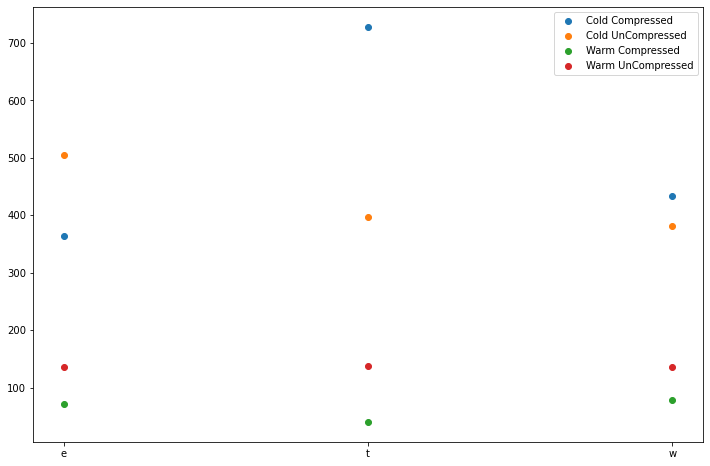

In [12]:
cold_access_comp = [364, 728, 434]
cold_access_uncomp = [504, 397, 382]

warm_access_comp = [72,40,78]
warm_access_uncomp = [136,138, 136]

plt.figure(figsize=(12,8))

plt.scatter(x=['e','t','w'], y=cold_access_comp, label="Cold Compressed")
plt.scatter(x=['e','t','w'], y=cold_access_uncomp, label="Cold UnCompressed")

plt.scatter(x=['e','t','w'], y=warm_access_comp, label="Warm Compressed")
plt.scatter(x=['e','t','w'], y=warm_access_uncomp, label="Warm UnCompressed")

plt.legend()

# Better Experiments below - various access sizes, cache cleared

## <font color="orange"> Process for experiments </font>

1. Cube sizes from $2^6$ to $2^{32}$, starting from biggest. Expressed as Cube Root

2. Read 4GB of data from different variable to make sure cache is clear

3. Pick a random starting point.

4. Read a cube from this starting point (see #1). Cube not guaranteed to be in single chunk

In [30]:
import zarr # Check version
import numpy as np
from matplotlib import pyplot as plt
from random import randint

zarr.__version__

'2.13.2'

In [16]:
chunk_sizes = [ 2**i for i in range(6,30)]

In [17]:
cube_root_size = [int(x ** (1. / 3)) for x in chunk_sizes]
cube_root_size[:5]

[3, 5, 6, 7, 10]

In [18]:
ncar_data = zarr.open("sciserver-experimental/ariel/tests")
ncar_data.info

Name,/
Type,zarr.hierarchy.Group
Read-only,False
Store type,zarr.storage.DirectoryStore
No. members,6
No. arrays,6
No. groups,0
Arrays,"e, p, t, u, v, w"


In [53]:
np.array(cube_root_size)

array([  3,   5,   6,   7,  10,  12,  15,  20,  25,  31,  40,  50,  63,
        80, 101, 127, 161, 203, 255, 322, 406, 511, 645, 812])

# Compressed
## Cold-cache access all chunk sizes 2^6 - 2^30

In [52]:
ncar_data['e'].info

Name,/e
Type,zarr.core.Array
Data type,float32
Shape,"(2048, 2048, 2048)"
Chunk shape,"(256, 256, 256)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,34359738368 (32.0G)
No. bytes stored,13989514907 (13.0G)


In [24]:
# Energy - 2.5 Compression Ratio
for i in range(len(cube_root_size)-1,-1,-1): # From 31st to 0-th (inclusive)
    _ = ncar_data['t'][0:1024,0:1024,0:1024]
    print(cube_root_size[i])
    
    random_start_point = 64 * randint(0, 16)
    %timeit -o -n 1 -r 1 ncar_data['e'][random_start_point:cube_root_size[i] + random_start_point,random_start_point:cube_root_size[i] + random_start_point,random_start_point:cube_root_size[i] + random_start_point]

812
24.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
645
13.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
511
3.08 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
406
4.08 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
322
1.28 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
255
728 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
203
1.15 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
161
982 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
127
131 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
101
175 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
80
848 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
63
97.6 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
50
92 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
40
118 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
31
148 ms ± 0 ns per loop (mean ± std. dev. of 1 run

Spikes up/down in time are when access happens between chunks. Cross-chunk access needs decompressing of both chunks

In [51]:
e_times = [24900, 13200, 3080, 4080, 1280, 728, 1150, 982, 131, 175, 848, 97.6, 92, 118, 148, 115, 117, 123, 20.8, 110, 94.8, 103, 122, 190]
e_times.reverse()

In [56]:
ncar_data['w'].info

Name,/w
Type,zarr.core.Array
Data type,float32
Shape,"(2048, 2048, 2048)"
Chunk shape,"(256, 256, 256)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,34359738368 (32.0G)
No. bytes stored,27329309819 (25.5G)


In [48]:
# w velocity field
# Cross-chunk
for i in range(len(cube_root_size)-1,-1,-1): # From 31st to 0-th (inclusive)
    _ = ncar_data['t'][0:1024,0:1024,0:1024]
#     print(cube_root_size[i])
    
    random_start_point = 64 * randint(0, 16)
    %timeit -o -n 1 -r 1 ncar_data['w'][random_start_point:cube_root_size[i] + random_start_point,random_start_point:cube_root_size[i] + random_start_point,random_start_point:cube_root_size[i] + random_start_point]

31.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
54.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
9.54 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
9.01 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.63 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.13 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.84 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.15 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.17 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
322 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
577 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
693 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
418 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
341 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
690 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
276 ms ± 0 ns per loop (mean ± std. dev.

In [54]:
cross_chunk_w_times = [31500, 54900, 9540, 9010, 2630, 2130, 2840, 2150, 2170, 322, 577, 693, 418, 341, 690, 276, 523, 401, 445, 338, 516, 385, 477, 483]
cross_chunk_w_times.reverse()

In [57]:
ncar_data['t'].info

Name,/t
Type,zarr.core.Array
Data type,float32
Shape,"(2048, 2048, 2048)"
Chunk shape,"(256, 256, 256)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,34359738368 (32.0G)
No. bytes stored,19025554335 (17.7G)


In [55]:
# Temperature
for i in range(len(cube_root_size)-1,-1,-1): # From 31st to 0-th (inclusive)
    _ = ncar_data['w'][0:1024,0:1024,0:1024]
#     print(cube_root_size[i])
    
    random_start_point = 64 * randint(0, 16)
    %timeit -o -n 1 -r 1 ncar_data['t'][random_start_point:cube_root_size[i] + random_start_point,random_start_point:cube_root_size[i] + random_start_point,random_start_point:cube_root_size[i] + random_start_point]

812
48.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
645
18.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
511
3.84 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
406
3.52 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
322
2.12 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
255
1.51 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
203
2.07 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
161
414 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
127
242 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
101
184 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
80
302 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
63
230 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
50
290 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
40
301 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
31
425 ms ± 0 ns per loop (mean ± std. dev. of 1 run

In [ ]:
t_times = [48300, 18600, 3840, 3520, 2120, 1510, 2070, 414, 242, 184, 302, 230, 290, 301, 425, 294, 273, 248, 227, 286, 170, 234, 257, 266]
t_times.reverse()

# Uncompressed
## Cold-cache access all chunk sizes 2^6 - 2^30

In [58]:
ncar_uncompressed = zarr.open("ncar_zarr_uncompressed")
ncar_uncompressed.info

Name,/
Type,zarr.hierarchy.Group
Read-only,False
Store type,zarr.storage.DirectoryStore
No. members,3
No. arrays,3
No. groups,0
Arrays,"e, t, w"


In [ ]:
ncar_uncompressed['e'].info

In [ ]:
# Energy field
for i in range(len(cube_root_size)-1,-1,-1): # From 31st to 0-th (inclusive)
    _ = ncar_uncompressed['t'][0:1024,0:1024,0:1024]
    print(cube_root_size[i])
    
    random_start_point = 64 * randint(0, 16)
    %timeit -o -n 1 -r 1 ncar_uncompressed['e'][random_start_point:cube_root_size[i] + random_start_point,random_start_point:cube_root_size[i] + random_start_point,random_start_point:cube_root_size[i] + random_start_point]

812
1min 4s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
645
23.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
511
15.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
406
44.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
322
3.96 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [ ]:
e_uncomp_times = [64000, 23600, 15500, 44800,3960,]

In [ ]:
ncar_uncompressed['w'].info

In [ ]:
# w velocity field
for i in range(len(cube_root_size)-1,-1,-1): # From 31st to 0-th (inclusive)
    _ = ncar_uncompressed['t'][0:1024,0:1024,0:1024]
    print(cube_root_size[i])
    
    random_start_point = 64 * randint(0, 16)
    %timeit -o -n 1 -r 1 ncar_uncompressed['w'][random_start_point:cube_root_size[i] + random_start_point,random_start_point:cube_root_size[i] + random_start_point,random_start_point:cube_root_size[i] + random_start_point]

In [ ]:
w_uncomp_times = []

In [ ]:
ncar_uncompressed['t'].info

In [ ]:
# temperature field
for i in range(len(cube_root_size)-1,-1,-1): # From 31st to 0-th (inclusive)
    _ = ncar_uncompressed['w'][0:1024,0:1024,0:1024]
    print(cube_root_size[i])
    
    random_start_point = 64 * randint(0, 16)
    %timeit -o -n 1 -r 1 ncar_uncompressed['t'][random_start_point:cube_root_size[i] + random_start_point,random_start_point:cube_root_size[i] + random_start_point,random_start_point:cube_root_size[i] + random_start_point]

In [ ]:
t_uncomp_times = []

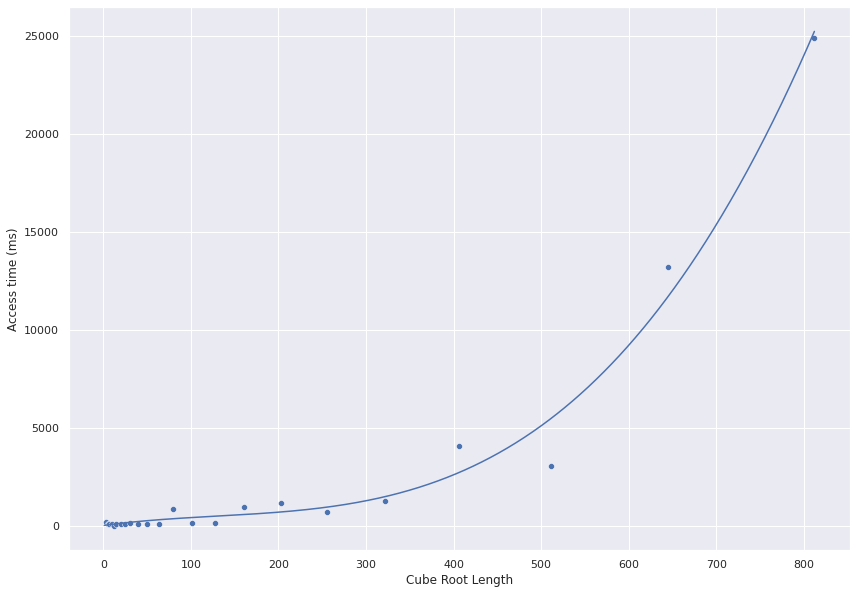

In [46]:
import seaborn as sns

sns.set(rc={'figure.figsize':(14,10)})
ax = sns.scatterplot(x=cube_root_size, y=e_times)

ax.set(xlabel='Cube Root Length', ylabel='Access time (ms)')

# https://stackoverflow.com/questions/31632637/label-axes-on-seaborn-barplot
mymodel = np.poly1d(np.polyfit(cube_root_size, e_times, 3))

myline = np.linspace(1, cube_root_size[len(cube_root_size)-1], 1000)
plt.plot(myline, mymodel(myline), color="orange")

plt.title("Cold Sequential Access Times")

plt.show()

## Warm-cache access all chunk sizes 2^6 - 2^30

In [ ]:
for i in range(len(cube_root_size)):
#     _ = ncar_data['t'][0:2048,0:2048,0:2048]
    print(cube_root_size[i])
    %timeit -o ncar_data['e'][0:cube_root_size[i],0:cube_root_size[i],0:cube_root_size[i]]

In [ ]:
for i in range(len(cube_root_size)):
#     _ = ncar_data['t'][0:2048,0:2048,0:2048]
    print(cube_root_size[i])
    %timeit -o ncar_data['w'][0:cube_root_size[i],0:cube_root_size[i],0:cube_root_size[i]]

In [ ]:
for i in range(len(cube_root_size)):
#     _ = ncar_data['t'][0:2048,0:2048,0:2048]
    print(cube_root_size[i])
    %timeit -o ncar_data['t'][0:cube_root_size[i],0:cube_root_size[i],0:cube_root_size[i]]

# <font color="red">Uncompressed</font>

In [ ]:
ncar_e_uncompressed = zarr.open("ncar_zarr_uncompressed/e")
ncar_e_uncompressed.info

## Cold-cache access all chunk sizes 2^6 - 2^30